# Twitter Classification

### Let's start with a few imports and definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import pandas as pd
from time import sleep
import sys
sys.path.append('c:\programdata\miniconda2\envs\py36\lib\site-packages')
import GetOldTweets3 as got
import re, os
import unicodedata
import codecs
import html.parser as HTMLParser
import nltk
import csv
from nltk.corpus import stopwords
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.collocations import *
from nltk.tag import StanfordNERTagger
from sklearn.feature_extraction.text import CountVectorizer

# general purpose functions
def strip_accents_unicode(text):
	return ''.join([c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c)])
def remove_html(text):
	return re.sub(r'( ?\.+ )+', ' . ', re.sub(r'<[^>]*>', ' . ', text))
def join_urls(text, url_pattern):
	m = re.search(url_pattern, text)
	while m:
		text = re.sub(url_pattern, m.group(3).replace("http://","").replace(".",""), text)
		m = re.search(url_pattern, text)
	return text
def join_compound_words(text, compound_pattern):
	m = re.search(compound_pattern, text)
	while m:
		text = re.sub(m.group(0), m.group(0).replace("-",""), text)
		m = re.search(compound_pattern, text)
	return text
def space_out_punctuation(text):
	text = re.sub(r',\s', ' , ', text)
	text = re.sub(r'\.\.\.\s', ' ... ', text)
	text = re.sub(r'\.\s', ' . ', text)
	text = re.sub(r';\s', ' ; ', text)
	text = re.sub(r':\s', ' : ', text)
	text = re.sub(r'\?\s', ' ? ', text)
	text = re.sub(r'!\s', ' ! ', text)
	text = re.sub(r'"', ' " ', text)
	text = re.sub(r'\'', ' \' ', text)
	text = re.sub(r'\s\(', ' ( ', text)
	text = re.sub(r'\)\s', ' ) ', text)
	text = re.sub(r'\s\[', ' [ ', text)
	text = re.sub(r'\]\s', ' ] ', text)
	text = re.sub(r'-', ' - ', text)
	text = re.sub(r'_', ' _ ', text)
	text = re.sub(r'\n', ' ', text)
	text = re.sub(r'\r', ' ', text)
	text = re.sub(r'\s+', ' ', text)
	return text
class CustomTokenizer(object):
	def __init__(self, tokenizer, stemmer, token_pattern, numeric_pattern):
		self.tokenizer = tokenizer
		self.stemmer = stemmer
		self.token_pattern = token_pattern
		self.numeric_pattern = numeric_pattern
	def __call__(self, doc):
		tokens = []
		for t in self.tokenizer(doc):
			if self.token_pattern.match(t) and not self.numeric_pattern.match(t):
				while "_" in t:
					splt = t.split("_")
					t = ''.join(splt[1:])
					tokens.append(self.stemmer(splt[0]))
				tokens.append(self.stemmer(t))
		return tokens
		#return [self.stemmer(t) for t in self.tokenizer(doc) \
		#			if self.token_pattern.match(t) and not self.numeric_pattern.match(t)]
class TextPreprocesser(object):
	def __init__(self, decode_error='strict', strip_accents='unicode', ignore_list=[], lowercase=True, \
						remove_html=True, join_urls=True, use_bigrams=True, use_ner=True, stanford_ner_path="", \
						use_lemmatizer=False, max_df=0.95, min_df=1, max_features=None):
		self.stanford_ner_path = stanford_ner_path		# path to stanford NER
		self.decode_error = decode_error				# options: {‘strict’, ‘ignore’, ‘replace’}
		self.strip_accents = strip_accents				# options: {‘ascii’, ‘unicode’, None}
		self.ignore_list = ignore_list
		self.lowercase = lowercase
		self.remove_html = remove_html
		self.join_urls = join_urls	
		self.use_bigrams = use_bigrams
		self.use_ner = use_ner
		self.use_lemmatizer = use_lemmatizer			# use lemmatizer instead of stemmer?
		self.max_df = max_df							# maximum document frequency
		self.min_df = min_df							# remove terms that occur in less than min_df documents
		self.max_features = max_features 				# keep only top-N words according to tf across corpus
		self.sentence_splitter = PunktSentenceTokenizer().tokenize 		# Punkt sentence splitter
		self.stemmer = SnowballStemmer("english").stem					# Snowball stemmer
		self.lemmatizer = WordNetLemmatizer().lemmatize 				# WordNet lemmatizer
		self.base_tokenizer = CountVectorizer().build_tokenizer()		# sklearn tokenizer works the best, I think...
		self.stop_words = stopwords.words("english")					# nltk list of 128 stopwords
		self.token_pattern = re.compile(r'(?u)\b(\w*[a-zA-Z_]\w+|\w+[a-zA-Z_]\w*)\b') 	# default value was r'(?u)\b\w\w+\b'
		self.numeric_pattern = re.compile(r'^[0-9]+$')					# number regex
		self.url_pattern = re.compile(r'((http://)?(www\..*?\.\w+).*?)\s')
		self.compound_pattern = re.compile(r'\w+(\-\w+)+')
		if self.use_lemmatizer:
			self.tokenizer = CustomTokenizer(self.base_tokenizer, self.lemmatizer, self.token_pattern, self.numeric_pattern)
		else:
			self.tokenizer = CustomTokenizer(self.base_tokenizer, self.stemmer, self.token_pattern, self.numeric_pattern)
	def find_nbest_bigrams(self, corpus, n, metric, min_freq):
		print("finding top-%d bigrams using %s..." % (n, metric))
		alltokens = []
		simplerTokenizer = CustomTokenizer(self.base_tokenizer, lambda x: x, re.compile(".*"), re.compile("^$"))
		for doc in corpus:
			for token in [t for t in simplerTokenizer(doc)]:
				alltokens.append(token)
		bigram_measures = nltk.collocations.BigramAssocMeasures()
		finder = BigramCollocationFinder.from_words(alltokens)
		finder.apply_freq_filter(min_freq) # bigrams must appear at least 5 times
		if metric.lower() == "pmi":
			best_bigrams = finder.nbest(bigram_measures.pmi, n)  # doctest: +NORMALIZE_WHITESPACE
		elif metric.lower() == "chi_sq":
			best_bigrams = finder.nbest(bigram_measures.chi_sq, n)  # doctest: +NORMALIZE_WHITESPACE
		else:
			raise Exception("Unknown metric for bigram finder")
		return best_bigrams
	def remove_punctuation(self, text):
		if not hasattr(self, 'simplerTokenizer'):
			self.simplerTokenizer = CustomTokenizer(self.base_tokenizer, lambda x: x, self.token_pattern, self.numeric_pattern)
		tokens = self.simplerTokenizer(text)
		return ' '.join(tokens)
	def tag_corpus_ner(self, corpus):
		if not hasattr(self, 'stanford_ner'):
			self.stanford_ner = StanfordNERTagger(self.stanford_ner_path+"classifiers/english.all.3class.distsim.crf.ser.gz", 
											self.stanford_ner_path+"stanford-ner.jar")
			self.stanford_ner._stanford_jar = self.stanford_ner_path+"stanford-ner.jar:"+self.stanford_ner_path+"lib/*"
		print("splitting sentences in corpus (for NER)...")
		corpus_sentences = []
		sentence_to_doc_map = {}
		sent_no = 0
		for d in xrange(len(corpus)):
			for sent in self.sentence_splitter(corpus[d]):
				corpus_sentences.append(sent)
				sentence_to_doc_map[sent_no] = d
				sent_no += 1
		tokenized_sentences = []
		for sent in corpus_sentences:
			tokenized_sentences.append([t for t in re.split(r'\s+', sent) if len(t) > 0])
		#tokenized_sentences = [re.split(r'\s+', sent) for sent in corpus_sentences]
		print("tagging sentences with Stanford NER...")
		tagged_sentences = self.stanford_ner.tag_sents(tokenized_sentences)
		# process NER output
		tagged_corpus = []
		current_doc_no = 0
		current_doc = []
		for i in xrange(len(tagged_sentences)):
			doc_no = sentence_to_doc_map[i]
			if doc_no == current_doc_no:
				current_doc += tagged_sentences[i]
			else:
				tagged_corpus.append(current_doc)
				current_doc = []
				current_doc_no = doc_no
		tagged_corpus.append(current_doc)
		# get dictionary of named entities per document
		named_entities = []
		for tagged_doc in tagged_corpus:
			tags = {}
			current_ne = []
			for token, tag in tagged_doc:
				if current_ne:
					if tag == "O" or (tag != "O" and tag != current_ne[-1][1]):
						tags[' '.join([t for t,_ in current_ne])] = current_ne[0][1]
						current_ne = []
				if tag != "O":
					current_ne.append((token, tag))
			if current_ne:
				tags[' '.join([t for t,_ in current_ne])] = current_ne[0][1]
			named_entities.append(tags)
		return tagged_corpus, named_entities
	def preprocess_corpus(self, corpus):
		print("preprocessing corpus...")
		print("corpus size:", len(corpus))
		# first pass over the corpus: prepare for NER
		print("first pass over the corpus...\n\tunescape characters")
		if self.remove_html: print("\tremove html")
		if self.strip_accents: print("\tstrip accents")
		if self.join_urls: print("\tjoin URLs")
		print("\tjoin compound words\n\tspace out punctuation")
		for d in xrange(len(corpus)):
			corpus[d] = HTMLParser.HTMLParser().unescape(corpus[d])+" "
			if self.remove_html:
				corpus[d] = remove_html(corpus[d])
			if self.strip_accents == 'unicode':
				corpus[d] = strip_accents_unicode(corpus[d])
			if self.join_urls:
				corpus[d] = join_urls(corpus[d], self.url_pattern)
			corpus[d] = join_compound_words(corpus[d], self.compound_pattern)
			corpus[d] = space_out_punctuation(corpus[d])
		if self.use_ner:
			tagged_corpus, named_entities = self.tag_corpus_ner(corpus)
			# debug NER
			fw = codecs.open("debug_NER.txt", "w", "utf-8")
			for tags in named_entities:
				fw.write(unicode(tags.items())+"\n")
			fw.close()
			print("merging named entities as single tokens...")
			for d in xrange(len(corpus)):
				tags = named_entities[d]
				for ne in tags:
					corpus[d] = corpus[d].replace(ne, re.sub(r'\s+', '', ne))
		# second pass over the corpus: remove punctuation and convert to lowercase 
		# (these were useful above for NER, but now can be removed)
		print("second pass over the corpus...")
		print("\tremove punctuation")
		if self.lowercase: print("\tconvert to lowercase")
		simplerTokenizer = CustomTokenizer(self.base_tokenizer, lambda x: x, self.token_pattern, self.numeric_pattern)
		for d in xrange(len(corpus)):
			corpus[d] = self.remove_punctuation(corpus[d])
			if self.lowercase:
				corpus[d] = corpus[d].lower()
		if self.use_bigrams:
			# find top N bigrams
			#best_bigrams = self.find_nbest_bigrams(corpus, 100, "pmi", 10)
			best_bigrams = self.find_nbest_bigrams(corpus, 100, "chi_sq", 10)
			# debug bigrams
			fw = codecs.open("debug_bigrams.txt", "w", "utf-8")
			for w1, w2 in best_bigrams:
				fw.write(w1+" "+w2+"\n")
			fw.close()
			print("merging bigrams as single tokens...")
			for d in xrange(len(corpus)):
				for w1, w2 in best_bigrams:
					corpus[d] = corpus[d].replace(w1+" "+w2, w1+w2)
		return corpus
	def convert_to_bag_of_words(self, corpus):
		print("converting corpus to bag-of-words format...")
		print("\ttokenize documents\n\tremove stopwords")
		print("\tapply lemmatizer" if self.use_lemmatizer else "\tapply stemmer")
		print("\tremove rare words\n\tremove very frequent words")
		vectorizer = CountVectorizer(input='content', 
							decode_error=self.decode_error,
							strip_accents=self.strip_accents,
							tokenizer=self.tokenizer, 
							stop_words=self.stop_words+self.ignore_list,
							lowercase=self.lowercase,
							max_df=self.max_df,
							min_df=self.min_df,
							max_features=self.max_features)
		dtm = vectorizer.fit_transform(corpus)  # a sparse matrix
		vocab = vectorizer.get_feature_names() 	# a list
		print("vocabulary size:", len(vocab))
		# debug vocabulary
		fw = codecs.open("vocabulary.txt", "w", "utf-8")
		for word in vocab:
			fw.write(word+"\n")
		fw.close()
		return dtm, vocab

In [2]:
class TweetCriteria:
    def __init__(self):
        self.maxTweets = 0
        self.within = "15mi"  
    def setUsername(self, username):
        self.username = username
        return self
    def setSince(self, since):
        self.since = since
        return self
    def setUntil(self, until):
        self.until = until
        return self
    def setQuerySearch(self, querySearch):
        self.querySearch = querySearch
        return self
    def setMaxTweets(self, maxTweets):
        self.maxTweets = maxTweets
        return self
    def setTopTweets(self, topTweets):
        self.topTweets = topTweets
        return self
    def setNear(self, near):
        self.near = near
        return self
    def setWithin(self, within):
        self.within = within
        return self

In [3]:
class Tweet:
    def __init__(self):
        pass
import urllib,json,re,datetime,sys,http.cookiejar as cookielib
from pyquery import PyQuery
class TweetManager:
    def __init__(self):
        pass
    @staticmethod
    def getTweets(tweetCriteria, receiveBuffer=None, bufferLength=100, proxy=None):
        refreshCursor = ''
        results = []
        resultsAux = []
        cookieJar = cookielib.CookieJar()
        if hasattr(tweetCriteria, 'username') and (tweetCriteria.username.startswith("\'") or tweetCriteria.username.startswith("\"")) and (tweetCriteria.username.endswith("\'") or tweetCriteria.username.endswith("\"")):
            tweetCriteria.username = tweetCriteria.username[1:-1]
        active = True
        while active:
            json = TweetManager.getJsonReponse(tweetCriteria, refreshCursor, cookieJar, proxy)
            if len(json['items_html'].strip()) == 0:
                break
            refreshCursor = json['min_position']
            scrapedTweets = PyQuery(json['items_html'])
            #Remove incomplete tweets withheld by Twitter Guidelines
            scrapedTweets.remove('div.withheld-tweet')
            tweets = scrapedTweets('div.js-stream-tweet')
            if len(tweets) == 0:
                break
            for tweetHTML in tweets:
                tweetPQ = PyQuery(tweetHTML)
                tweet = models.Tweet()
                usernameTweet = tweetPQ("span:first.username.u-dir b").text()
                txt = re.sub(r"\s+", " ", tweetPQ("p.js-tweet-text").text().replace('# ', '#').replace('@ ', '@'))
                retweets = int(tweetPQ("span.ProfileTweet-action--retweet span.ProfileTweet-actionCount").attr("data-tweet-stat-count").replace(",", ""))
                favorites = int(tweetPQ("span.ProfileTweet-action--favorite span.ProfileTweet-actionCount").attr("data-tweet-stat-count").replace(",", ""))
                dateSec = int(tweetPQ("small.time span.js-short-timestamp").attr("data-time"))
                id = tweetPQ.attr("data-tweet-id")
                permalink = tweetPQ.attr("data-permalink-path")
                geo = ''
                geoSpan = tweetPQ('span.Tweet-geo')
                if len(geoSpan) > 0:
                    geo = geoSpan.attr('title')
                tweet.id = id
                tweet.permalink = 'https://twitter.com' + permalink
                tweet.username = usernameTweet
                tweet.text = txt
                tweet.date = datetime.datetime.fromtimestamp(dateSec)
                tweet.retweets = retweets
                tweet.favorites = favorites
                tweet.mentions = " ".join(re.compile('(@\\w*)').findall(tweet.text))
                tweet.hashtags = " ".join(re.compile('(#\\w*)').findall(tweet.text))
                tweet.geo = geo
                results.append(tweet)
                resultsAux.append(tweet)
                if receiveBuffer and len(resultsAux) >= bufferLength:
                    receiveBuffer(resultsAux)
                    resultsAux = []
                if tweetCriteria.maxTweets > 0 and len(results) >= tweetCriteria.maxTweets:
                    active = False
                    break
        if receiveBuffer and len(resultsAux) > 0:
            receiveBuffer(resultsAux)
        return results
    @staticmethod
    def getJsonReponse(tweetCriteria, refreshCursor, cookieJar, proxy):
        url = "https://twitter.com/i/search/timeline?f=tweets&q=%s&src=typd&max_position=%s"
        urlGetData = ''
        if hasattr(tweetCriteria, 'username'):
            urlGetData += ' from:' + tweetCriteria.username
        if hasattr(tweetCriteria, 'querySearch'):
            urlGetData += ' ' + tweetCriteria.querySearch
        if hasattr(tweetCriteria, 'near'):
            urlGetData += "&near:" + tweetCriteria.near + " within:" + tweetCriteria.within
        if hasattr(tweetCriteria, 'since'):
            urlGetData += ' since:' + tweetCriteria.since
        if hasattr(tweetCriteria, 'until'):
            urlGetData += ' until:' + tweetCriteria.until
        if hasattr(tweetCriteria, 'topTweets'):
            if tweetCriteria.topTweets:
                url = "https://twitter.com/i/search/timeline?q=%s&src=typd&max_position=%s"
        url = url % (urllib.quote(urlGetData), urllib.quote(refreshCursor))
        headers = [
            ('Host', "twitter.com"),
            ('User-Agent', "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.181 Safari/537.36"),
            ('Accept', "application/json, text/javascript, */*; q=0.01"),
            ('Accept-Language', "de,en-US;q=0.7,en;q=0.3"),
            ('X-Requested-With', "XMLHttpRequest"),
            ('Referer', url),
            ('Connection', "keep-alive")
        ]
        if proxy:
            opener = urllib.request.build_opener(urllib.request.ProxyHandler({'http': proxy, 'https': proxy}), urllib.request.HTTPCookieProcessor(cookieJar))
        else:
            opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor(cookieJar))
        opener.addheaders = headers
        try:
            response = opener.open(url)
            jsonResponse = response.read()
        except:
            print("Twitter weird response. Try to see on browser: https://twitter.com/search?q=%s&src=typd" % urllib.quote(urlGetData))
        #return
        dataJson = json.loads(jsonResponse)
        return dataJson

## Data Scraping

In [4]:
# DATA SCRAPING:

# define a function that collects the usernames of students and teachers from twitter via "followerwonk.com"

    # 5 tweets per person, 50 people per page, 10 pages per class, 2 classes (student/teacher) -> 5,000 tweets
    # can only scrape 1 page per search, instead of taking 10 pages with range 500-1000 followers (sorted highest followers first)
def followerwonk_search(keyword,min_frs,max_frs): 
    r = requests.get('https://followerwonk.com/bio/?q='+keyword+'&q_type=all&frmin=0&frmax=0&flmin='
                     +str(min_frs)+'&flmax='+str(max_frs)+'&stctmin=0&stctmax=0') 
    data = r.text
    soup = BeautifulSoup(data, "html5lib")
    tweets=[]
    for node in soup.findAll('span',attrs={"class":"person_scrn"}):
        username = ''.join(node.findAll(text=True))
        tweets.append(username)
    return tweets # returns list of usernames with above specified search criteria

In [5]:
# run this code to scrape usernames until list of lists is full
# for students
student_peeps = []
for min_fwrs in range(500,1500,100):
    max_fwrs = min_fwrs + 100
    forlist = followerwonk_search('student',min_fwrs,max_fwrs)
    student_peeps.append(forlist)
student_peeps
# save the new parts of each new scrape to perm list -- site only allows for limited amount of free searches
student_peeps_perm = student_peeps # initialize list
for i in range(0,10,1):
    if len(student_peeps[i])>1:
        student_peeps_perm[i]=student_peeps[i]
student_peeps_perm

# for teachers
teacher_peeps = []
for min_fwrs in range(500,1500,100):
    max_fwrs = min_fwrs + 100
    forlist = followerwonk_search('teacher',min_fwrs,max_fwrs)
    teacher_peeps.append(forlist)
student_peeps
# save the new parts of each new scrape to perm list -- site only allows for limited amount of free searches
teacher_peeps_perm = teacher_peeps # initialize list
for i in range(0,10,1):
    if len(teacher_peeps[i])>1:
        teacher_peeps_perm[i]=teacher_peeps[i]
teacher_peeps_perm

[['@kbergeronmath',
  '@thaisgermano',
  '@RlCHARDHARRISON',
  '@alicianykamp',
  '@kkemp70',
  '@operakaty',
  '@stupotwakefield',
  '@teachercookie72',
  '@Mrs_K_Lyon',
  '@denoay',
  '@boydwinona',
  '@WillFosterIV',
  '@KaitlynMarie011',
  '@coryseborg',
  '@kimballiu34',
  '@EatcherVeggies',
  '@aysentg',
  '@lakeCDSBEO',
  '@dvk1979',
  '@JessicaKWebster',
  '@shun_uchimura',
  '@_TheBum',
  '@KellieFMejia',
  '@livijayallard',
  '@jilaniat',
  '@piyatida191',
  '@hidderoorda',
  '@ClassrmChuckles',
  '@malinireddy',
  '@JacksonTeachSci',
  '@Elischico',
  '@virdyaaa',
  '@danieljamesross',
  '@LydeciaBrown',
  '@brown_eyes_89',
  '@santispilates',
  '@faalbloushii',
  '@PMFontana',
  '@JGMcKenney',
  '@TaylorWurth',
  '@justHAH_nah',
  '@hallerae5',
  '@Mona9210',
  '@beccamarie4',
  '@JamieFgolf',
  '@tips4specialkid',
  '@BenMonaco20',
  '@timzowino',
  '@JoMaz_',
  '@mslight12'],
 ['@piaze',
  '@irenecov',
  '@peter5150',
  '@robertdhargrove',
  '@intothebleach',
  '@tsedge',

Module "got" defined at the bottom of the page and taken from github courtesy of
https://github.com/Jefferson-Henrique/GetOldTweets-python/blob/master/LICENSE

In [6]:
# storeTweets function
def storeTweets(username_list,num_tweets):
    tweet_dict={}
    df=pd.DataFrame(columns=['Text','Favorites','Mentions','Hashtags'])
    for username in username_list:
        user_tweets=[]
        tweetCriteria = got.manager.TweetCriteria().setUsername(username).setMaxTweets(num_tweets)
        tweets = got.manager.TweetManager.getTweets(tweetCriteria)[:]
        for t in tweets:
            user_tweets.append({'Text':t.text,'Favorites':t.favorites,'Mentions':t.mentions,'Hashtags':t.hashtags})
        tweet_dict[username]=user_tweets
        df1=pd.DataFrame.from_dict(tweet_dict[username][:])
        df1['username']=username
        df1.set_index('username')
        df=pd.concat([df,df1],sort=True)
    return df

In [7]:
# scrape first 5 tweets from each user in each username list into dataframe
# multiple scrapes in succession unsuccessful -- worked well once a successful sleep time interval was integrated
# I put triple apostrophes around code that I did not want to run more than necessary
'''student_df_list = []
for i in range(0,10,1):
    df_ = storeTweets(student_peeps_perm[i],5)
    student_df_list.append(df_)
    sleep(10.0)
student_df_concat = pd.concat([df_i for df_i in student_df_list],sort=True) # all student tweets dataframe
teacher_df_list = []
for i in range(0,10,1):
    df_ = storeTweets(teacher_peeps_perm[i],5)
    teacher_df_list.append(df_)
    sleep(10.0)
teacher_df_concat = pd.concat([df_i for df_i in teacher_df_list],sort=True)''' # all teacher tweets dataframe
# save "student" tweets to csv file w/ code:
'''student_df_concat.to_csv('C:/.../twitter_student_tweets.csv')'''
# save "teacher" tweets to csv file w/ code:
'''teacher_df_concat.to_csv('C:/.../twitter_teacher_tweets.csv')'''

"teacher_df_concat.to_csv('C:/.../twitter_teacher_tweets.csv')"

## Data Cleaning

In [8]:
# DATA CLEANING

# read csv into df
twitter_teacher_tweets = pd.read_csv('C:/Users/acer.DESKTOP-NM2UJ22/Springboard/Springboard/twitter_teacher_tweets.csv')
twitter_student_tweets = pd.read_csv('C:/Users/acer.DESKTOP-NM2UJ22/Springboard/Springboard/twitter_student_tweets.csv')
# eliminate usernames occuring in both classes
teachers_list = twitter_teacher_tweets.username.unique()
students_list = twitter_student_tweets.username.unique()
intersection = set(teachers_list).intersection(set(students_list))
twitter_student_df = twitter_student_tweets[~twitter_student_tweets.username.isin(intersection)].drop('Unnamed: 0',axis=1).replace(np.nan, '', regex=True)
twitter_student_df['class'] = 'student'
twitter_student_df['cc'] = 0 # class code
twitter_teacher_df = twitter_teacher_tweets[~twitter_teacher_tweets.username.isin(intersection)].drop('Unnamed: 0',axis=1).replace(np.nan, '', regex=True)
twitter_teacher_df['class'] = 'teacher'
twitter_teacher_df['cc'] = 1 # class code
twitter_classroom_df = pd.concat([twitter_student_df,twitter_teacher_df]).reset_index()
twitter_classroom_df[['username','class']].groupby('username').count().reset_index().groupby('class').count()

# import translator to detect and keep only the english tweets
from googletrans import Translator
translator = Translator()
twitter_classroom_df['lang'] = 'unknown' # initialize language of each tweet as unknown
'''for i in range(0,4338,50): # detect and label each tweet by language code (english = 'en')
    twitter_classroom_df.lang[i:i+50] = twitter_classroom_df.Text[i:i+50].apply(lambda x: translator.detect(x).lang)
    sleep(20.0)'''

twitter_classroom_df.loc[~twitter_classroom_df.lang.isin(['en'])]
# non-english tweets (some are simply gibberish but detected as non-english)
'''print(twitter_classroom_df.loc[twitter_classroom_df.lang.isin(['unknown'])])''' # check for any undetected languages ... empty
# save dataframe with identified language to csv file w/ code:
'''twitter_classroom_df.to_csv('C:/.../twitter_classroom_with_langs.csv')'''

"twitter_classroom_df.to_csv('C:/.../twitter_classroom_with_langs.csv')"

In [9]:
# DEFINE TEXT CLEANING FUNCTION: remove links, punctuation, and stop-words and make words lowercase
import re
import string
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
tok = TweetTokenizer()
lemmatizer=WordNetLemmatizer()
def text_cleaner(text):
    remove_via_at = re.sub(r'via @', '@', text)
    no_url = re.sub(r'www.[^ ]+|https?://[^ ]+|pic.twitter.[^ ]+', '', remove_via_at)
    exclude = set(string.punctuation+'’'+'‘'+'…')
    exclude.remove('#')
    exclude.remove('@')
    no_url = ''.join(ch for ch in no_url if ch not in exclude)
    return (" ".join([lemmatizer.lemmatize(word).lower() for word in tok.tokenize(no_url)])).strip()

In [10]:
# data cleaning and TEXT PRE-PROCESSING

twitter_classroom_df_with_langs = pd.read_csv('C:/Users/acer.DESKTOP-NM2UJ22/Springboard/Springboard/twitter_classroom_with_langs.csv')
classroom_tweets = twitter_classroom_df_with_langs.loc[twitter_classroom_df_with_langs.lang.isin(['en'])]
classroom_tweets = classroom_tweets.reset_index().drop(['level_0','Unnamed: 0','index','lang'],axis=1).replace(np.nan, '', regex=True)
classroom_tweets # only contains tweets from students and teachers in english
classroom_tweets['num_hash'] = classroom_tweets.Hashtags.str.count("#")
classroom_tweets['num_ment'] = classroom_tweets.Mentions.str.count("@")
classroom_tweets['num_links'] = classroom_tweets.Text.str.count(r'www.[^ ]+|https?://[^ ]+|pic.twitter.[^ ]+')
classroom_tweets['text'] = classroom_tweets.Text.apply(text_cleaner)
classroom_tweets_cleaned = classroom_tweets[['username','class','cc','text','Favorites','num_hash','num_ment','num_links']]
classroom_tweets_cleaned.columns = ['username','class','cc','text','num_favs','num_hash','num_ment','num_links']
classroom_tweets_cleaned

,username,class,cc,text,num_favs,num_hash,num_ment,num_links
0,@RyanAkers,student,0,tough way to end a season with such a good tea...,1,0,0,0
1,@RyanAkers,student,0,at approximately 906pm my resting heart rate i...,4,0,0,1
2,@RyanAkers,student,0,who is zion havent heard anything about him al...,1,0,0,0
3,@RyanAkers,student,0,i just hope my team get the chance to see that...,1,0,0,0
4,@RyanAkers,student,0,i wa cheering for auburn because i want kentuc...,1,0,0,0
5,@cindyruccolo,student,0,chronic inflammation @wordpressdotcom,0,0,1,1
6,@cindyruccolo,student,0,abraham hicks no commercials listen to this ev...,1,0,1,1
7,@cindyruccolo,student,0,hey tom,1,0,0,0
8,@cindyruccolo,student,0,tonight jimi ruccolo band at blue jean blues i...,1,0,0,0
9,@cindyruccolo,student,0,there is love and there is feari choose love,0,0,0,0


Text(0.5,1,'length of tweet')

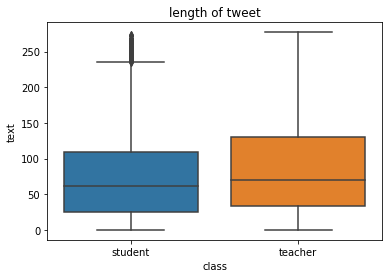

In [11]:
# length of tweet boxplot
import seaborn as sns
len_text = classroom_tweets_cleaned['text'].apply(len)
sns.boxplot(x=classroom_tweets_cleaned['class'],y=len_text).set_title("length of tweet")

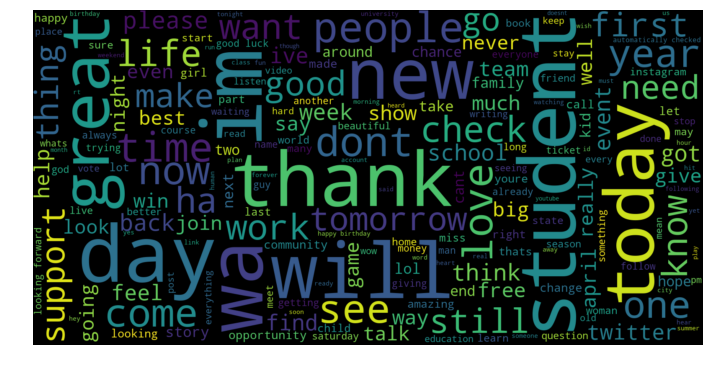

In [12]:
# WordCloud for Students
studwordcloud_tweets = classroom_tweets_cleaned[classroom_tweets_cleaned.cc == 0]
studwordcloud_string = []
for t in studwordcloud_tweets.text:
    studwordcloud_string.append(t)
studwordcloud_string = pd.Series(studwordcloud_string).str.cat(sep=' ')
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(studwordcloud_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

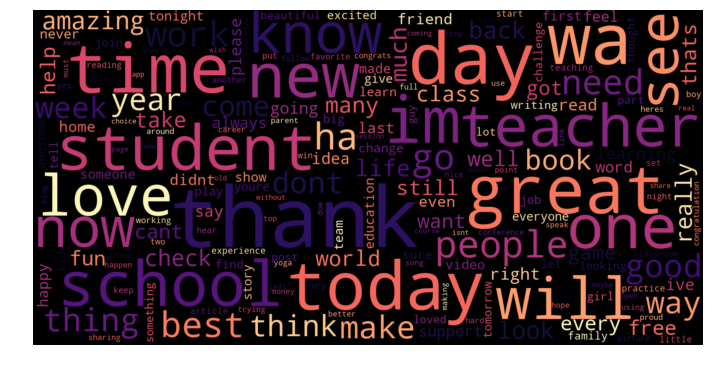

In [13]:
# WordCloud for Teachers
teachwordcloud_tweets = classroom_tweets_cleaned[classroom_tweets_cleaned.cc == 1]
teachwordcloud_string = []
for t in teachwordcloud_tweets.text:
    teachwordcloud_string.append(t)
teachwordcloud_string = pd.Series(teachwordcloud_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(teachwordcloud_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Exploratory Analysis

In [14]:
from collections import Counter
def term_freq_counter():
    stud_vocab=[]
    teach_vocab=[]
    for t in classroom_tweets_cleaned[classroom_tweets_cleaned.cc == 0].text:
        for word in tok.tokenize(t):
            stud_vocab.append(word)
    for t in classroom_tweets_cleaned[classroom_tweets_cleaned.cc == 1].text:
        for word in tok.tokenize(t):
            teach_vocab.append(word)
    stud_terms = Counter(stud_vocab).keys()
    stud_tf = Counter(stud_vocab).values()
    teach_terms = Counter(teach_vocab).keys()
    teach_tf = Counter(teach_vocab).values()
    entire_vocab = stud_vocab+teach_vocab
    all_terms = Counter(entire_vocab).keys()
    all_tf = Counter(entire_vocab).values()
    term_freq_df = pd.DataFrame([stud_tf,teach_tf,all_tf],index=['students','teachers','total'],columns=all_terms).transpose()
    return term_freq_df[term_freq_df.total>0].fillna(0.0).applymap(np.int64)
tfc=term_freq_counter()
tfc.sort_index(axis=0)

,students,teachers,total
#,0,2,3
#0314,0,1,1
#11m,0,0,1
#16,0,0,1
#18,0,0,1
#1businesstoolforactors,5,1,5
#20,0,0,1
#2018wrapped,0,0,1
#2019resulution,1,1,1
#305cafecito,0,0,1


In [15]:
# TRAIN TEST SPLIT + CountVectorizer & TfidfVectorizer + LogisticRegression & RandomForestClassifier & MultinomialNB
# DEFINE Function to score combinations of a vectorizer and classifier, with stop_word and n_gram parameters

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

y = classroom_tweets_cleaned['cc']
X = classroom_tweets_cleaned['text']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=2)
cvec = CountVectorizer()
tvec = TfidfVectorizer()
lr = LogisticRegression()
rf = RandomForestClassifier()
nb = MultinomialNB()

def vec_clf_gram_stop_df(x_train, x_test, y_train, y_test, vectorizer=cvec, stop_words=None, ngram_range=(1, 1), classifier=lr):
    vectorizer = vectorizer.set_params(stop_words=stop_words, ngram_range=ngram_range)
    vecXtrain = vectorizer.fit_transform(x_train.values)
    vecXtest = vectorizer.transform(x_test.values)
    clf = classifier
    clf.fit(vecXtrain, y_train)
    y_pred = clf.predict(vecXtest)
    parameters = {lr:{'C':[1,10]}, #herehere
                  rf:{'n_estimators':[10,100],'max_depth':[None]},
                  nb:{'alpha':[0.1,1,10]}}
    parameters = parameters[clf]
    GSCV = GridSearchCV(clf, parameters, cv=5, scoring='recall_macro')
    GSCV.fit(vecXtrain,y_train)
    #print("score: {0}\tparams: {1}".format(round(GSCV.best_score_,4), GSCV.best_params_))
    return round(GSCV.best_score_,4)

C:\ProgramData\Anaconda3.0\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=2)
cvecXtrain = cvec.fit_transform(X_train)
cvecXtest = cvec.transform(X_test)
nb.fit(cvecXtrain, y_train)
y_pred = nb.predict(cvecXtest)
tweet_features = np.array(cvec.get_feature_names())
x = np.eye(cvecXtest.shape[1])
probs = nb.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)
tweet_features = tweet_features[ind]
probs = 1 - np.exp(probs[ind])
predictive_power = np.abs(probs-0.5)
unpredictive_features = list(tweet_features[predictive_power<0.2]) # 0.2 later established to be optimal value generally

In [17]:
def term_freq_func(stop_words=None):
    cnt_vzr = CountVectorizer(stop_words=stop_words)
    cnt_vzr.fit(classroom_tweets_cleaned['text'].values)
    student_tweet_matrix = cnt_vzr.transform(classroom_tweets_cleaned[classroom_tweets_cleaned.cc == 0].text)
    teacher_tweet_matrix = cnt_vzr.transform(classroom_tweets_cleaned[classroom_tweets_cleaned.cc == 1].text)
    stud_tf = np.sum(student_tweet_matrix,axis=0)
    teach_tf = np.sum(teacher_tweet_matrix,axis=0)
    stud = np.squeeze(np.asarray(stud_tf))
    teach = np.squeeze(np.asarray(teach_tf))
    term_freq_df = pd.DataFrame([stud,teach,stud+teach],index=['students','teachers','total'],columns=cnt_vzr.get_feature_names()).transpose()
    return term_freq_df[term_freq_df.total>1] #return terms occuring more than once in entirety
term_freq_df_NONE = term_freq_func(None)
term_freq_df_UF = term_freq_func(unpredictive_features) # predictive_power < 0.2
term_freq_df_ENG = term_freq_func('english')
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(unpredictive_features)
term_freq_df_ENGnUF = term_freq_func(stopwords)
term_freq_df_NONE.sort_values(by='total', ascending=False).iloc[:5]

,students,teachers,total
the,710,1005,1715
to,651,843,1494
and,427,571,998
of,334,479,813
for,354,435,789


In [18]:
print("\tTeach words  P(teacher | word)")
for f, p in zip(tweet_features[:5], probs[:5]):
    print("{:>20}".format(f), "{:.2f}".format(p))
print("\tStud words   P(student | word)")
for f, p in zip(tweet_features[-5:], probs[-5:]):
    print("{:>20}".format(f), "{:.2f}".format(p))

	Teach words  P(teacher | word)
               loved 0.94
           knowledge 0.93
            teachers 0.93
                list 0.93
                yoga 0.93
	Stud words   P(student | word)
              duluth 0.11
             started 0.10
              alerts 0.09
               tango 0.09
                  31 0.09


In [19]:
pred_inds=np.where((probs<0.10)|(probs>0.90))
non_pred_inds=np.where((probs>0.49)&(probs<0.51))
print(tweet_features[pred_inds])
print(tweet_features[non_pred_inds])

['loved' 'knowledge' 'teachers' 'list' 'yoga' 'brilliant' 'started'
 'alerts' 'tango' '31']
['got' 'such' 'ive' 'people' 'child' 'back' 'lot' 'girl' 'wait' 'at'
 'change' 'doing' 'from' 'more' 'new' 'team' 'feel' 'up' 'out' 'are' 'me']


In [20]:
term_freq_df_UF.sort_values(by='total', ascending=False).iloc[:5]

,students,teachers,total
school,26,72,98
best,20,50,70
teacher,6,47,53
book,14,35,49
class,10,29,39


In [21]:
term_freq_df_ENG.sort_values(by='total', ascending=False).iloc[:5]

,students,teachers,total
just,93,89,182
day,74,92,166
im,94,72,166
wa,74,90,164
time,54,81,135


In [22]:
term_freq_df_ENGnUF.sort_values(by='total', ascending=False).iloc[:5]

,students,teachers,total
school,26,72,98
best,20,50,70
teacher,6,47,53
book,14,35,49
class,10,29,39


In [23]:
from scipy.stats import hmean, norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())
def normcdf_hmean(term_freq_df):
    term_freq_df_teacher_rate = term_freq_df['teachers'] * 1./term_freq_df['total']
    term_freq_df_student_rate = term_freq_df['students'] * 1./term_freq_df['total']
    term_freq_df_teach_freq_pct = term_freq_df['teachers'] * 1./term_freq_df['teachers'].sum()
    term_freq_df_stud_freq_pct = term_freq_df['students'] * 1./term_freq_df['students'].sum()
    term_freq_df_teach_rate_normcdf = normcdf(term_freq_df_teacher_rate)
    term_freq_df_teach_freq_pct_normcdf = normcdf(term_freq_df_teach_freq_pct)
    term_freq_df['teach_normcdf_hmean'] = hmean([term_freq_df_teach_rate_normcdf, term_freq_df_teach_freq_pct_normcdf])
    term_freq_df_stud_rate_normcdf = normcdf(term_freq_df_student_rate)
    term_freq_df_stud_freq_pct_normcdf = normcdf(term_freq_df_stud_freq_pct)
    term_freq_df['stud_normcdf_hmean'] = hmean([term_freq_df_stud_rate_normcdf, term_freq_df_stud_freq_pct_normcdf])
    print("Terms most commonly associated with teachers")
    print(term_freq_df.sort_values(by='teach_normcdf_hmean', ascending=False).iloc[:5])
    print("Terms most commonly associated with students")
    print(term_freq_df.sort_values(by='stud_normcdf_hmean', ascending=False).iloc[:5])
print('stopwords = None')
normcdf_hmean(term_freq_df_NONE)
print('stopwords = UF')
normcdf_hmean(term_freq_df_UF)
print('stopwords = english')
normcdf_hmean(term_freq_df_ENG)
print('stopwords = UF & english')
normcdf_hmean(term_freq_df_ENGnUF)

stopwords = None
Terms most commonly associated with teachers
         students  teachers  total  teach_normcdf_hmean  stud_normcdf_hmean
teacher         6        47     53             0.863654            0.263116
school         26        72     98             0.808100            0.453667
best           20        50     70             0.772371            0.461879
thanks         28        63     91             0.770644            0.503086
amazing        16        38     54             0.738193            0.460003
Terms most commonly associated with students
          students  teachers  total  teach_normcdf_hmean  stud_normcdf_hmean
april           28         9     37             0.257181            0.833686
event           25         7     32             0.233833            0.825128
tomorrow        36        18     54             0.354764            0.824455
first           36        21     57             0.394894            0.804187
google          19         3     22             0.16

## Applying ML Techniques & Scoring

In [24]:
#LogReg - (stop_word=None) uni-c, uni-t,  bi-c,  bi-t, tri-c, tri-t| uni-c, uni-t,  bi-c,  bi-t, tri-c, tri-t ('english')
score_lr_vec_gram_stop = [0.6083,0.6017,0.6108,0.5962,0.6127,0.5946,0.6092,0.6002,0.6088,0.6038,0.6069,0.5967]
# best LogReg score: 0.6127 cvec None trigram C=1

# NaiveBayes  -   (None)  uni-c, uni-t,  bi-c,  bi-t, tri-c, tri-t| uni-c, uni-t, bi-c,  bi-t, tri-c, tri-t ('english')
score_nb_vec_gram_stop = [0.6328,0.6329,0.6186,0.6157,0.594,0.6017,0.6350,0.6353,0.6179,0.6160,0.598,0.6027]
# best NaiveBayes score: 0.6353 tvec 'english' unigram alpha=0.1

# RandomForest uni-tvec w/ stop_words=unpredictive_features
vec_clf_gram_stop_df(X_train,X_test,y_train,y_test,tvec,unpredictive_features,(1, 1),rf)

0.7206

In [25]:
def feature_power_test(vec,clf):
    cut_off = list(np.linspace(0.01,0.3,30))
    scores=[]
    for i in cut_off:
        unpred_feats_ = list(tweet_features[predictive_power<i])
        scores.append(vec_clf_gram_stop_df(X_train,X_test,y_train,y_test,vec,unpred_feats_,(1, 1),clf))
    return scores
feature_power_test_tvec_nb = feature_power_test(tvec,nb)
feature_power_test_tvec_lr = feature_power_test(tvec,lr)
feature_power_test_cvec_nb = feature_power_test(cvec,nb)
feature_power_test_cvec_lr = feature_power_test(cvec,lr)

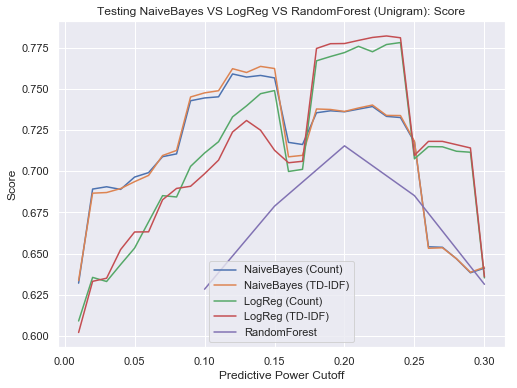

In [26]:
import seaborn as sns
sns.set()
plt.figure(figsize=(8,6))
lstlinspc=list(np.linspace(0.01,0.3,30))
ax = sns.lineplot(x=lstlinspc, y=feature_power_test_cvec_nb, label='NaiveBayes (Count)')
ax = sns.lineplot(x=lstlinspc, y=feature_power_test_tvec_nb, label='NaiveBayes (TD-IDF)') 
ax = sns.lineplot(x=lstlinspc, y=feature_power_test_cvec_lr, label='LogReg (Count)')
ax = sns.lineplot(x=lstlinspc, y=feature_power_test_tvec_lr, label='LogReg (TD-IDF)')
ax = sns.lineplot(x=[0.1,0.15,0.2,0.25,0.3], y=[0.6283,0.6788,0.7155,0.6852,0.6313], label='RandomForest')
plt.title("Testing NaiveBayes VS LogReg VS RandomForest (Unigram): Score")
plt.xlabel("Predictive Power Cutoff")
plt.ylabel("Score")
plt.legend()
plt.show()

**Score by count/td-idf vectorizer and uni/bi/tri_gram**
     
     NaiveBayes: count uni 0.7384 bi 0.7333 tri 0.7262 
                 tdidf uni 0.739  bi 0.7356 tri 0.7274
         
         LogReg: count uni 0.7613 bi 0.7692 tri 0.7674 ... logreg-countvec-bigram has the highest score
                 tdidf uni 0.7696 bi 0.7689 tri 0.7667
     
     RandForest: count uni 0.7109 bi 0.7075 tri 0.7043 
                 tdidf uni 0.7151 bi 0.7128 tri 0.7079 ... all w/ custom_stop_words such that predictive_power < 0.2

In [27]:
cut_off = list(np.linspace(0.01,0.3,30))
logregcvecuniscores=[]
logregcvecbiscores=[]
logregcvectriscores=[]
best_score_lrcvuni=0
best_score_lrcvbi=0
best_score_lrcvtri=0
for i in cut_off:
    unpred_feats_ = list(tweet_features[predictive_power<i])
    score_uni=vec_clf_gram_stop_df(X_train,X_test,y_train,y_test,cvec,unpred_feats_,(1, 1),lr)
    score_bi=vec_clf_gram_stop_df(X_train,X_test,y_train,y_test,cvec,unpred_feats_,(1, 2),lr)
    score_tri=vec_clf_gram_stop_df(X_train,X_test,y_train,y_test,cvec,unpred_feats_,(1, 3),lr)
    logregcvecuniscores.append(score_uni)
    logregcvecbiscores.append(score_bi)
    logregcvectriscores.append(score_tri)
    if score_uni>best_score_lrcvuni:
        best_score_lrcvuni=score_uni
        x_pos_uni=i
    if score_bi>best_score_lrcvbi:
        best_score_lrcvbi=score_bi
        x_pos_bi=i
    if score_tri>best_score_lrcvtri:
        best_score_lrcvtri=score_tri
        x_pos_tri=i
print('uni',round(x_pos_uni,2),best_score_lrcvuni)
print('bi',round(x_pos_bi,2),best_score_lrcvbi)
print('tri',round(x_pos_tri,2),best_score_lrcvtri)

uni 0.24 0.7783
bi 0.24 0.7766
tri 0.24 0.7763


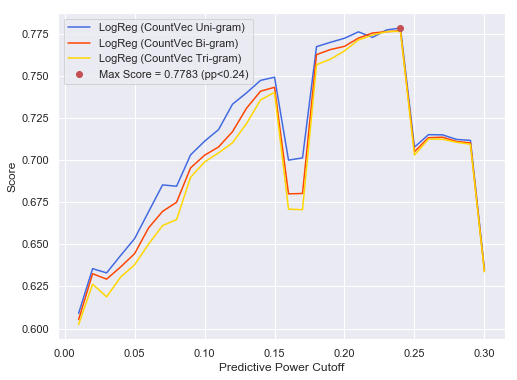

In [28]:
sns.set()
plt.figure(figsize=(8,6))
lstlinspc=list(np.linspace(0.01,0.3,30))
ax = sns.lineplot(x=lstlinspc, y=logregcvecuniscores, label='LogReg (CountVec Uni-gram)', color='royalblue')
ax = sns.lineplot(x=lstlinspc, y=logregcvecbiscores, label='LogReg (CountVec Bi-gram)', color='orangered')
ax = sns.lineplot(x=lstlinspc, y=logregcvectriscores, label='LogReg (CountVec Tri-gram)', color='gold')
ax = ax.plot(0.24,0.7783,'ro',label='Max Score = 0.7783 (pp<0.24)')
plt.xlabel("Predictive Power Cutoff")
plt.ylabel("Score")
plt.legend()
plt.show()

In [29]:
from gensim.models import word2vec
'''model = word2vec.Word2Vec(X_train, workers=10,sample=1e-3)
model.init_sims(replace=True)
model_name = "student_teacher_word2vec_model"
model.save(model_name)'''

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


'model = word2vec.Word2Vec(X_train, workers=10,sample=1e-3)\nmodel.init_sims(replace=True)\nmodel_name = "student_teacher_word2vec_model"\nmodel.save(model_name)'

In [30]:
from gensim.models import Word2Vec
model = Word2Vec.load("student_teacher_word2vec_model")
num_features=100
def makeFeatureVec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float64")
    nwords = 0.001
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    featureVec = np.divide(featureVec,nwords)
    return featureVec
def getAvgFeatureVecs(tweets, model, num_features):
    counter = 0
    tweetFeatureVecs = np.zeros((len(tweets),num_features),dtype="float64")
    for tweet in tweets:
        tweetFeatureVecs[counter] = makeFeatureVec(tweet, model, num_features)
        counter = counter + 1
    return tweetFeatureVecs
trainDataVecs = getAvgFeatureVecs(X_train, model, num_features)
testDataVecs = getAvgFeatureVecs(X_test, model, num_features)
lr = LogisticRegression()
rf = RandomForestClassifier()
nb = MultinomialNB()
print("Accuracy for LogReg\nAccuracy for RandForest")
for clf in [lr,rf]:
    clf = clf.fit(trainDataVecs, y_train.values)
    pred = clf.predict(testDataVecs)
    print(accuracy_score(y_test, pred).round(4))

C:\ProgramData\Anaconda3.0\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Accuracy for LogReg
Accuracy for RandForest
0.5123
0.5613


Using a word2vec model is essentially useless for analyzing these tweets

In [31]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df_ENG.stud_normcdf_hmean), high=max(term_freq_df_ENG.stud_normcdf_hmean))
p = figure(x_axis_label='teacher-ness', y_axis_label='student-ness')
p.circle('teach_normcdf_hmean','stud_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df_ENG,color={'field': 'stud_normcdf_hmean', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...

In [32]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

def accuracy_score_(pipeline, x_train, y_train, x_test, y_test):
    vect_class_fit = pipeline.fit(x_train, y_train)
    y_pred = vect_class_fit.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    print("Accuracy Score: ",score.round(4))
    return score
def classifier_comparator(vectorizer=cvec, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        clf_accuracy = accuracy_score_(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,clf_accuracy))
    return result
result = classifier_comparator(stop_words=None,ngram_range=(1,3))

Validation result for Logistic Regression
Accuracy Score:  0.6131
Validation result for Linear SVC
Accuracy Score:  0.5913
Validation result for LinearSVC with L1-based feature selection
Accuracy Score:  0.5722
Validation result for Multinomial NB
Accuracy Score:  0.6403
Validation result for Bernoulli NB
Accuracy Score:  0.6322
Validation result for Ridge Classifier
Accuracy Score:  0.5886
Validation result for AdaBoost
Accuracy Score:  0.5804
Validation result for Perceptron
Accuracy Score:  0.6076
Validation result for Passive-Aggresive
Accuracy Score:  0.5777
Validation result for Nearest Centroid
Accuracy Score:  0.5286


## FINAL SCORE

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=3)
def FINAL_SCORE(x_train, x_test, y_train, y_test, vectorizer=cvec, stop_words=None, ngram_range=(1, 1), classifier=lr):
    vectorizer = vectorizer.set_params(stop_words=stop_words, ngram_range=ngram_range)
    vecXtrain = vectorizer.fit_transform(x_train.values)
    vecXtest = vectorizer.transform(x_test.values)
    clf = classifier
    clf.fit(vecXtrain, y_train)
    y_pred = clf.predict(vecXtest)
    return accuracy_score(y_test, y_pred).round(2)
nonpred_feats = list(tweet_features[predictive_power<0.24])
FINAL_SCORE(X_train,X_test,y_train,y_test,vectorizer=cvec,stop_words=nonpred_feats,ngram_range=(1, 1),classifier=LogisticRegression(C=10))

0.73

In [51]:
def best_final_params(x_train, x_test, y_train, y_test, vectorizer=cvec, stop_words=None, ngram_range=(1, 1), classifier=lr):
    vectorizer = vectorizer.set_params(stop_words=stop_words, ngram_range=ngram_range)
    vecXtrain = vectorizer.fit_transform(x_train.values)
    vecXtest = vectorizer.transform(x_test.values)
    clf = classifier
    clf.fit(vecXtrain, y_train)
    parameters = {lr:{'C':[1,10]},
                  rf:{'n_estimators':[10,100],'max_depth':[None]},
                  nb:{'alpha':[0.1,1,10]}}
    parameters = parameters[clf]
    GSCV = GridSearchCV(clf, parameters, cv=5, scoring='recall_macro')
    GSCV.fit(vecXtrain,y_train)
    print(GSCV.best_estimator_.score(vecXtest,y_test))
    return (round(GSCV.best_score_,4), GSCV.best_params_, GSCV.best_estimator_)
best_final_params(X_train,X_test,y_train,y_test,vectorizer=cvec,stop_words=nonpred_feats,ngram_range=(1, 2),classifier=lr)

0.7438692098092643


(0.7564,
 {'C': 1},
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False))